In [61]:
import pandas as pd
import numpy as np 

# ChEMBL Database
----

**ChEMBL: a large-scale bioactivity database for drug discovery**
Anna Gaulton,1 Louisa J. Bellis,1 A. Patricia Bento,1 Jon Chambers,1 Mark Davies,1 Anne Hersey,1 Yvonne Light,1 Shaun McGlinchey,1 David Michalovich,2 Bissan Al-Lazikani,3 and John P. Overington1,*

ChEMBL is an Open Data database containing binding, functional and ADMET information for a large number of drug-like bioactive compounds. These data are manually abstracted from the primary published literature on a regular basis, then further curated and standardized to maximize their quality and utility across a wide range of chemical biology and drug-discovery research problems. Currently, the database contains **5.4 million bioactivity measurements for more than 1 million compounds and 5200 protein targets. Access is available through a web-based interface, data downloads and web services at: https://www.ebi.ac.uk/chembldb.**

In [62]:
from chembl_webresource_client.new_client import new_client

## Acute Myeloid Leukemia 

In [63]:
target = new_client.target
target_query = target.search('FLT3')
targets = pd.DataFrame(target_query)

targets.head()

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Mus musculus,Receptor-type tyrosine-protein kinase FLT3,18.0,False,CHEMBL2034796,"[{'accession': 'Q00342', 'component_descriptio...",SINGLE PROTEIN,10090
1,"[{'xref_id': 'P36888', 'xref_name': None, 'xre...",Homo sapiens,Tyrosine-protein kinase receptor FLT3,16.0,False,CHEMBL1974,"[{'accession': 'P36888', 'component_descriptio...",SINGLE PROTEIN,9606
2,[],Homo sapiens,VHL/FLT3,15.0,False,CHEMBL4523735,"[{'accession': 'P36888', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
3,[],Homo sapiens,Protein cereblon/Tyrosine-protein kinase recep...,15.0,False,CHEMBL4630730,"[{'accession': 'P36888', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606


### Retrieve Bioactivity Data from Tyrosine-Protein-Kinase Receptor 
---

IC50: The half maximal inhibitory concentration (IC50) is a measure of the potency of a substance in inhibiting a specific biological or biochemical function.

* The smalller the value the better - less concentration needed for inhibition.

In [64]:
activity = new_client.activity
res = activity.filter(target_chembl_id = 'CHEMBL1974').filter(standard_type = 'IC50')

In [65]:
# Select first 1000 rows 
res = res[0:1000]

In [66]:
df = pd.DataFrame(res)

In [67]:
df.head(3)

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,866063,[],CHEMBL766072,Inhibition of chimeric PDGF receptor with FLT-...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tyrosine-protein kinase receptor FLT3,9606,None,None,IC50,uM,UO_0000065,None,0.128
1,None,872532,[],CHEMBL766072,Inhibition of chimeric PDGF receptor with FLT-...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tyrosine-protein kinase receptor FLT3,9606,None,None,IC50,uM,UO_0000065,None,0.22
2,None,872564,[],CHEMBL766072,Inhibition of chimeric PDGF receptor with FLT-...,B,None,None,BAO_0000190,BAO_0000219,...,Homo sapiens,Tyrosine-protein kinase receptor FLT3,9606,None,None,IC50,uM,UO_0000065,None,8.79


In [68]:
df = df[df['standard_value'].notnull()]

In [69]:
df.to_csv('resources/bioactivity_data.csv', index = False)

## Classification

In [70]:
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']

df = df[selection]

df['standard_value'] = df['standard_value'].astype(float)

In [71]:
# Duplicate Assays - Take Average
df.duplicated(subset = 'molecule_chembl_id').sum()

81

In [73]:
df = df.pivot_table(index = selection[:2],
                                values = selection[-1],
                                aggfunc = np.mean).reset_index()

In [74]:
def classification(df):
    if df['standard_value'] >= 10000:
        return 'inactive'
    elif df['standard_value'] <= 1000:
        return 'active'
    else:
        return 'intermediate'

In [75]:
df['bioactivity_class'] = df.apply(classification, axis = 1)

In [76]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL102301,COc1cc2ncnc(N3CCN(/C(S)=N\Cc4ccc5c(c4)OCO5)CC3...,14900.0,inactive
1,CHEMBL102346,COc1cc2ncnc(N3CCN(C(=O)Nc4ccc(Oc5ccccc5)cc4)CC...,230.0,active
2,CHEMBL103307,O=C1Nc2ccccc2/C1=C\c1ccc(O)cc1,1800.0,intermediate
3,CHEMBL103667,Cc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)Nc2ccc(OCCN3CCO...,30000.0,inactive
4,CHEMBL104067,COc1cc2ncnc(N3CCN(C(=O)Nc4ccc(C(C)C)cc4)CC3)c2...,50.0,active


In [77]:
df['bioactivity_class'].value_counts()

active          654
intermediate    129
inactive        126
Name: bioactivity_class, dtype: int64

## Calculate Lipinski descriptors 

Lipinski's rule of five or Pfizer's rule of five is used to evaluate the druglikeness of acompound. Lipinski's rule is as stated in the following:

* No more than 5 hydrogen bond donors (the total number of nitrogen-hydrogen and oxygen-hydrogen bonds)   
* No more than 10 hydrogen bond acceptors (all nitrogen or oxygen atoms)
* A molecular mass < 500 daltons         
* A calculated octanol-water partition coefficient (Clog P) < 5

The name 5 referes to all the values are mutiples of 5s

### Calculating Descriptors

In [78]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [79]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [80]:
df_lipinski = lipinski(df['canonical_smiles'])

In [81]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,467.551,2.98370,1.0,8.0
1,485.544,4.79340,1.0,7.0
2,237.258,2.88490,2.0,2.0
3,527.669,5.98642,2.0,6.0
4,435.528,4.12450,1.0,6.0
...,...,...,...,...
904,288.255,2.21550,4.0,6.0
905,288.255,1.48070,4.0,6.0
906,272.256,2.50990,3.0,5.0
907,493.615,4.59032,2.0,7.0


In [82]:
# Joining lip
combined = pd.merge(df, df_lipinski, left_index = True, right_index = True)

In [83]:
combined[combined.duplicated(subset = 'molecule_chembl_id', keep = False)]

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors


## Convert IC50 to pIC50 

To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50).

This custom function pIC50() will accept a DataFrame as input and will:

Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10
Take the molar value and apply -log10
Delete the standard_value column and create a new pIC50 column

In [84]:
combined['standard_value'].describe()

count       909.000000
mean       3234.063178
std        8590.701154
min           0.200000
25%          21.000000
50%         140.000000
75%        1500.000000
max      100000.000000
Name: standard_value, dtype: float64

The standard value has uneven distribution. Convert to -log10 for distribution.

In [85]:
def log10(df):
    molar = df['standard_value']/10**9 # Convert to nM to M 
    log10 = -np.log10(molar)
    return log10 

combined['pIC50'] = df.apply(log10, axis = 1) 

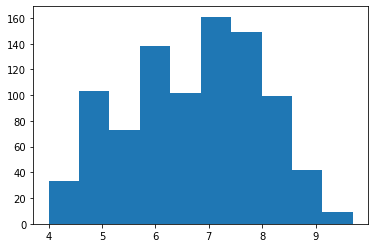

<Figure size 432x288 with 0 Axes>

In [86]:
import matplotlib.pyplot as plt 

plt.hist(combined['pIC50'])
plt.show()

plt.savefig('Output/figures/Histogram_Norm.pdf')

In [87]:
# Remove intermediate - ambigious molecules - for analysis 
combined = combined[combined['bioactivity_class'] != 'intermediate']

In [90]:
# Exporting as SaveFile
combined.to_csv('Output/bioactivity.csv', index = False)

### Chemical Space Analysis via Lipinski descriptors 

In [91]:
import seaborn as sns 

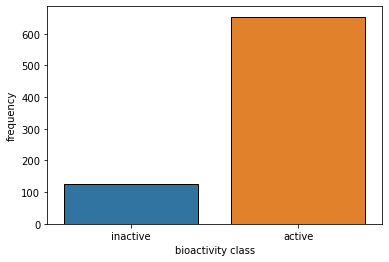

<Figure size 432x288 with 0 Axes>

In [109]:
sns.countplot(x = 'bioactivity_class', data = combined,
             edgecolor = 'black')

plt.xlabel('bioactivity class')
plt.ylabel('frequency')
plt.show()

plt.savefig('Output/figures/Count_Plot.jpg')

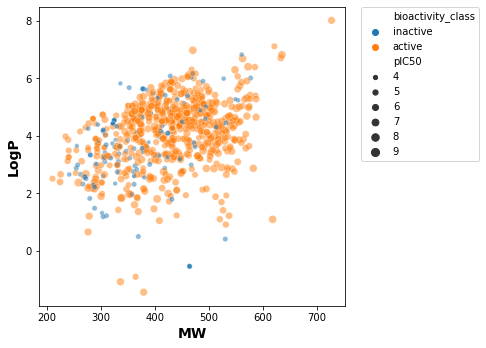

In [110]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x = 'MW', y = 'LogP', data = combined, 
               hue = 'bioactivity_class', size = 'pIC50', alpha = 0.5)


plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

plt.savefig('Output/figures/Chem_Space_Analysis.pdf')
plt.show()


From this graph, the whether a compound is active or inactive against FLT3 is difficult to tell. This suggest that deeper machine learning algorithims may aid in learning. 

## Statistical T-Test for Lipinski Values 

In [94]:
descriptors = ['pIC50', 'MW', 'LogP', 'NumHDonors', 'NumHAcceptors']

In [95]:
from scipy.stats import stats

def t_test(descriptors):
    list_ = []
    for element in descriptors:
        
        # splitting active and inactive
        active = combined[combined['bioactivity_class'] == 'active']
        inactive = combined[combined['bioactivity_class'] == 'inactive']
        active = active[[element]]
        inactive = inactive[[element]]
        
        # t-test for statistical signficance
        results, pvalue = stats.ttest_ind(active, inactive)
        
        if pvalue > 0.05:
            interpretation = 'Same distribution (fail to reject H0)'
        else:
            interpretation = 'Different distribution (reject H0)'
            
        # appending results
        list_.append([element, results[0], pvalue[0], interpretation])
        
    df_results = pd.DataFrame(list_, columns = ['Descriptor', 'results', 'pvalue', 'interpretation'])
    
    return df_results

In [96]:
results = t_test(descriptors)

## pIC50

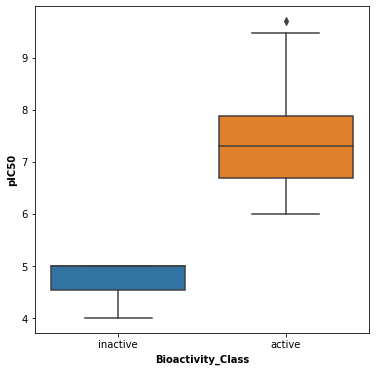

,Descriptor,results,pvalue,interpretation
0,pIC50,33.402186,1.937665e-152,Different distribution (reject H0)


<Figure size 432x288 with 0 Axes>

In [100]:
plt.figure(figsize=(6, 6))
sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = combined)

plt.xlabel('Bioactivity_Class', fontweight = 'bold')
plt.ylabel('pIC50', fontweight = 'bold')

plt.show()
plt.savefig('Output/figures/pIC50.pdf')
results[results.index == 0]



## MW

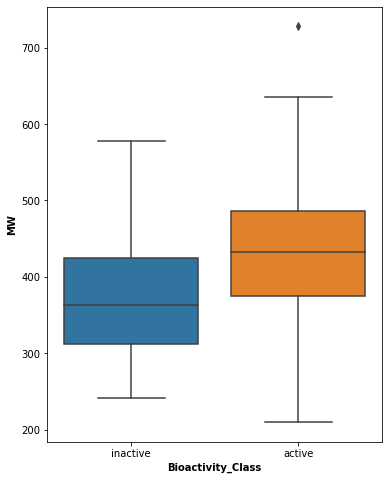

<Figure size 432x288 with 0 Axes>

In [98]:
plt.figure(figsize=(6, 8))
sns.boxplot(x = 'bioactivity_class', y = 'MW', data = combined)

plt.xlabel('Bioactivity_Class', fontweight = 'bold')
plt.ylabel('MW', fontweight = 'bold')

plt.show()

results[results.index == 1]

plt.savefig('Output/figures/MW.pdf')

## LogP

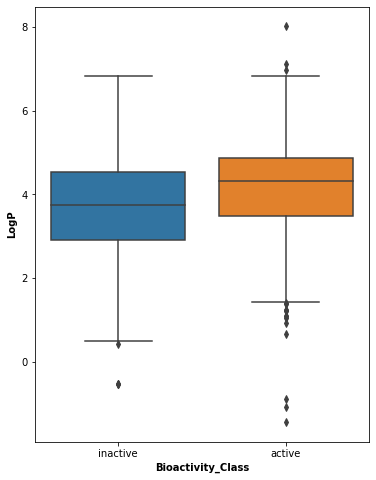

,Descriptor,results,pvalue,interpretation
2,LogP,3.647737,0.000282,Different distribution (reject H0)


<Figure size 432x288 with 0 Axes>

In [101]:
plt.figure(figsize=(6, 8))
sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = combined)

plt.xlabel('Bioactivity_Class', fontweight = 'bold')
plt.ylabel('LogP', fontweight = 'bold')

plt.show()
plt.savefig('Output/figures/logP.pdf')


results[results.index == 2]



## NumHDonors

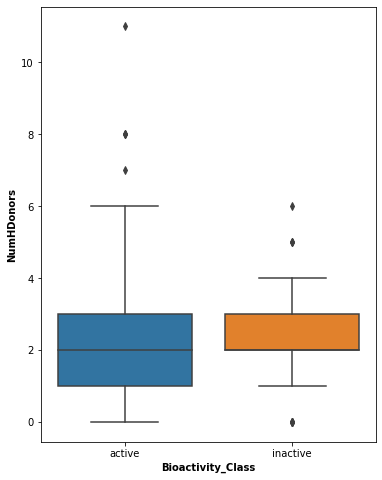

<Figure size 432x288 with 0 Axes>

In [34]:
plt.figure(figsize=(6, 8))
sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = combined)

plt.xlabel('Bioactivity_Class', fontweight = 'bold')
plt.ylabel('NumHDonors', fontweight = 'bold')

plt.show()

results[results.index == 3]

plt.savefig('Output/figures/NumHDonors.pdf')

## NumHAcceptors

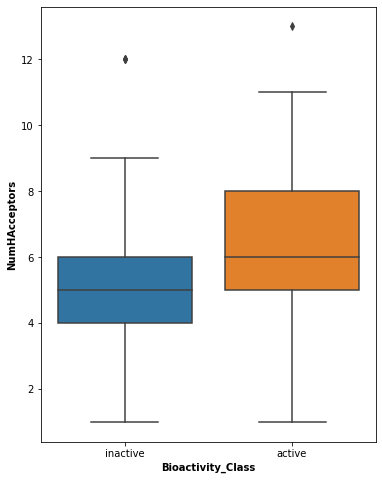

,Descriptor,results,pvalue,interpretation
4,NumHAcceptors,5.194867,2.618861e-07,Different distribution (reject H0)


<Figure size 432x288 with 0 Axes>

In [102]:
plt.figure(figsize=(6, 8))
sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = combined)

plt.xlabel('Bioactivity_Class', fontweight = 'bold')
plt.ylabel('NumHAcceptors', fontweight = 'bold')

plt.show()
plt.savefig('Output/figures/NumHAcceptors.pdf')
results[results.index == 4]



In [103]:
results

,Descriptor,results,pvalue,interpretation
0,pIC50,33.402186,1.937665e-152,Different distribution (reject H0)
1,MW,7.251568,9.960885e-13,Different distribution (reject H0)
2,LogP,3.647737,2.821961e-04,Different distribution (reject H0)
3,NumHDonors,3.379502,7.623462e-04,Different distribution (reject H0)
4,NumHAcceptors,5.194867,2.618861e-07,Different distribution (reject H0)


## Calculating Molecular Descriptors 

In [104]:
padel = combined[['canonical_smiles', 'molecule_chembl_id']]

In [105]:
padel.head()

,canonical_smiles,molecule_chembl_id
0,COc1cc2ncnc(N3CCN(/C(S)=N\Cc4ccc5c(c4)OCO5)CC3...,CHEMBL102301
1,COc1cc2ncnc(N3CCN(C(=O)Nc4ccc(Oc5ccccc5)cc4)CC...,CHEMBL102346
3,Cc1ccc(-n2nc(C(C)(C)C)cc2NC(=O)Nc2ccc(OCCN3CCO...,CHEMBL103667
4,COc1cc2ncnc(N3CCN(C(=O)Nc4ccc(C(C)C)cc4)CC3)c2...,CHEMBL104067
5,COc1cc2ncnc(N3CCN(C(=O)Nc4ccc(C#N)cc4)CC3)c2cc1OC,CHEMBL106966


In [106]:
padel.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [107]:
! cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [108]:
! bash padel.sh

Processing CHEMBL102301 in molecule.smi (1/780). 
Processing CHEMBL102346 in molecule.smi (2/780). 
Processing CHEMBL103667 in molecule.smi (3/780). 
Processing CHEMBL104067 in molecule.smi (4/780). 
Processing CHEMBL106966 in molecule.smi (5/780). 
Processing CHEMBL107599 in molecule.smi (6/780). 
Processing CHEMBL1077291 in molecule.smi (7/780). 
Processing CHEMBL1083839 in molecule.smi (8/780). 
Processing CHEMBL1084450 in molecule.smi (9/780). Average speed: 3.28 s/mol.
Processing CHEMBL1085921 in molecule.smi (10/780). Average speed: 1.70 s/mol.
Processing CHEMBL1086983 in molecule.smi (11/780). Average speed: 1.22 s/mol.
Processing CHEMBL1093099 in molecule.smi (12/780). Average speed: 0.94 s/mol.
Processing CHEMBL1093100 in molecule.smi (13/780). Average speed: 0.79 s/mol.
Processing CHEMBL1095374 in molecule.smi (14/780). Average speed: 0.74 s/mol.
Processing CHEMBL1095686 in molecule.smi (15/780). Average speed: 0.64 s/mol.
Processing CHEMBL1095687 in molecule.smi (16/780). Av

Processing CHEMBL1782187 in molecule.smi (111/780). Average speed: 0.12 s/mol.
Processing CHEMBL1782188 in molecule.smi (112/780). Average speed: 0.12 s/mol.
Processing CHEMBL1784637 in molecule.smi (113/780). Average speed: 0.12 s/mol.
Processing CHEMBL1793892 in molecule.smi (114/780). Average speed: 0.12 s/mol.
Processing CHEMBL1793896 in molecule.smi (115/780). Average speed: 0.12 s/mol.
Processing CHEMBL1807386 in molecule.smi (116/780). Average speed: 0.12 s/mol.
Processing CHEMBL1807388 in molecule.smi (117/780). Average speed: 0.12 s/mol.
Processing CHEMBL1807389 in molecule.smi (118/780). Average speed: 0.12 s/mol.
Processing CHEMBL1807392 in molecule.smi (119/780). Average speed: 0.12 s/mol.
Processing CHEMBL1807466 in molecule.smi (120/780). Average speed: 0.12 s/mol.
Processing CHEMBL1807467 in molecule.smi (121/780). Average speed: 0.12 s/mol.
Processing CHEMBL1807470 in molecule.smi (124/780). Average speed: 0.12 s/mol.
Processing CHEMBL1807469 in molecule.smi (123/780). 

Processing CHEMBL1944700 in molecule.smi (215/780). Average speed: 0.10 s/mol.
Processing CHEMBL1944701 in molecule.smi (216/780). Average speed: 0.10 s/mol.
Processing CHEMBL1944870 in molecule.smi (217/780). Average speed: 0.10 s/mol.
Processing CHEMBL1944871 in molecule.smi (218/780). Average speed: 0.10 s/mol.
Processing CHEMBL1945046 in molecule.smi (220/780). Average speed: 0.10 s/mol.
Processing CHEMBL1944872 in molecule.smi (219/780). Average speed: 0.10 s/mol.
Processing CHEMBL1945048 in molecule.smi (222/780). Average speed: 0.10 s/mol.
Processing CHEMBL1945047 in molecule.smi (221/780). Average speed: 0.10 s/mol.
Processing CHEMBL1945049 in molecule.smi (223/780). Average speed: 0.10 s/mol.
Processing CHEMBL1945050 in molecule.smi (224/780). Average speed: 0.10 s/mol.
Processing CHEMBL1945051 in molecule.smi (225/780). Average speed: 0.10 s/mol.
Processing CHEMBL1945052 in molecule.smi (226/780). Average speed: 0.10 s/mol.
Processing CHEMBL1945170 in molecule.smi (227/780). 

Processing CHEMBL2032285 in molecule.smi (319/780). Average speed: 0.09 s/mol.
Processing CHEMBL2035041 in molecule.smi (320/780). Average speed: 0.09 s/mol.
Processing CHEMBL2035042 in molecule.smi (321/780). Average speed: 0.09 s/mol.
Processing CHEMBL2035043 in molecule.smi (322/780). Average speed: 0.09 s/mol.
Processing CHEMBL2035046 in molecule.smi (324/780). Average speed: 0.09 s/mol.
Processing CHEMBL2035044 in molecule.smi (323/780). Average speed: 0.09 s/mol.
Processing CHEMBL2035047 in molecule.smi (325/780). Average speed: 0.09 s/mol.
Processing CHEMBL2035048 in molecule.smi (326/780). Average speed: 0.09 s/mol.
Processing CHEMBL2035049 in molecule.smi (327/780). Average speed: 0.09 s/mol.
Processing CHEMBL2035050 in molecule.smi (328/780). Average speed: 0.09 s/mol.
Processing CHEMBL2035052 in molecule.smi (330/780). Average speed: 0.09 s/mol.
Processing CHEMBL2035051 in molecule.smi (329/780). Average speed: 0.09 s/mol.
Processing CHEMBL2035053 in molecule.smi (331/780). 

Processing CHEMBL2180882 in molecule.smi (425/780). Average speed: 0.09 s/mol.
Processing CHEMBL2181082 in molecule.smi (426/780). Average speed: 0.09 s/mol.
Processing CHEMBL2181083 in molecule.smi (427/780). Average speed: 0.09 s/mol.
Processing CHEMBL2181084 in molecule.smi (428/780). Average speed: 0.09 s/mol.
Processing CHEMBL2181085 in molecule.smi (429/780). Average speed: 0.09 s/mol.
Processing CHEMBL2181086 in molecule.smi (430/780). Average speed: 0.09 s/mol.
Processing CHEMBL2181087 in molecule.smi (431/780). Average speed: 0.09 s/mol.
Processing CHEMBL2181088 in molecule.smi (432/780). Average speed: 0.09 s/mol.
Processing CHEMBL2181310 in molecule.smi (433/780). Average speed: 0.09 s/mol.
Processing CHEMBL2181311 in molecule.smi (434/780). Average speed: 0.09 s/mol.
Processing CHEMBL2181312 in molecule.smi (435/780). Average speed: 0.09 s/mol.
Processing CHEMBL2181313 in molecule.smi (436/780). Average speed: 0.09 s/mol.
Processing CHEMBL2181314 in molecule.smi (437/780). 

Processing CHEMBL237551 in molecule.smi (531/780). Average speed: 0.08 s/mol.
Processing CHEMBL237552 in molecule.smi (532/780). Average speed: 0.08 s/mol.
Processing CHEMBL237553 in molecule.smi (533/780). Average speed: 0.08 s/mol.
Processing CHEMBL237767 in molecule.smi (535/780). Average speed: 0.08 s/mol.
Processing CHEMBL237570 in molecule.smi (534/780). Average speed: 0.08 s/mol.
Processing CHEMBL238010 in molecule.smi (536/780). Average speed: 0.08 s/mol.
Processing CHEMBL238222 in molecule.smi (537/780). Average speed: 0.08 s/mol.
Processing CHEMBL238223 in molecule.smi (538/780). Average speed: 0.08 s/mol.
Processing CHEMBL238224 in molecule.smi (539/780). Average speed: 0.08 s/mol.
Processing CHEMBL2385195 in molecule.smi (540/780). Average speed: 0.08 s/mol.
Processing CHEMBL2385543 in molecule.smi (541/780). Average speed: 0.08 s/mol.
Processing CHEMBL2386788 in molecule.smi (542/780). Average speed: 0.08 s/mol.
Processing CHEMBL2386789 in molecule.smi (543/780). Average s

Processing CHEMBL375670 in molecule.smi (636/780). Average speed: 0.08 s/mol.
Processing CHEMBL376077 in molecule.smi (637/780). Average speed: 0.08 s/mol.
Processing CHEMBL376245 in molecule.smi (638/780). Average speed: 0.08 s/mol.
Processing CHEMBL376307 in molecule.smi (639/780). Average speed: 0.08 s/mol.
Processing CHEMBL376787 in molecule.smi (640/780). Average speed: 0.08 s/mol.
Processing CHEMBL377193 in molecule.smi (641/780). Average speed: 0.08 s/mol.
Processing CHEMBL377335 in molecule.smi (642/780). Average speed: 0.08 s/mol.
Processing CHEMBL377652 in molecule.smi (644/780). Average speed: 0.08 s/mol.
Processing CHEMBL377567 in molecule.smi (643/780). Average speed: 0.08 s/mol.
Processing CHEMBL378133 in molecule.smi (645/780). Average speed: 0.08 s/mol.
Processing CHEMBL378477 in molecule.smi (646/780). Average speed: 0.08 s/mol.
Processing CHEMBL378924 in molecule.smi (647/780). Average speed: 0.08 s/mol.
Processing CHEMBL379087 in molecule.smi (648/780). Average speed

Processing CHEMBL519982 in molecule.smi (744/780). Average speed: 0.08 s/mol.
Processing CHEMBL519590 in molecule.smi (743/780). Average speed: 0.08 s/mol.
Processing CHEMBL520144 in molecule.smi (745/780). Average speed: 0.08 s/mol.
Processing CHEMBL520717 in molecule.smi (746/780). Average speed: 0.08 s/mol.
Processing CHEMBL521470 in molecule.smi (747/780). Average speed: 0.08 s/mol.
Processing CHEMBL522892 in molecule.smi (748/780). Average speed: 0.08 s/mol.
Processing CHEMBL55415 in molecule.smi (750/780). Average speed: 0.08 s/mol.
Processing CHEMBL535 in molecule.smi (749/780). Average speed: 0.08 s/mol.
Processing CHEMBL554993 in molecule.smi (751/780). Average speed: 0.08 s/mol.
Processing CHEMBL556684 in molecule.smi (752/780). Average speed: 0.08 s/mol.
Processing CHEMBL569880 in molecule.smi (753/780). Average speed: 0.08 s/mol.
Processing CHEMBL571040 in molecule.smi (754/780). Average speed: 0.08 s/mol.
Processing CHEMBL572878 in molecule.smi (755/780). Average speed: 0.